In [1]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import seaborn as sns
import time
import re, io, nltk, torch 
from nltk.corpus import stopwords
from numpy import linalg as LA
from numpy.linalg import norm
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
from sklearn.utils.class_weight import compute_class_weight
from gensim import utils, matutils  
from gensim.corpora.dictionary import Dictionary
from six import string_types, integer_types
from six.moves import zip, range
from numpy import linalg as LA
from sklearn.preprocessing import Normalizer
from scipy import stats
from gensim.utils import deprecated
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from collections import Counter
from scipy.spatial import distance
from numpy.random import binomial
from scipy.stats import bernoulli
import numpy as np
import matplotlib.pyplot as plt


import transformers
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertTokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


In [2]:
train =pd.read_csv("../Fine-Tuning/CSV_Harassment/train_format.csv")
val=pd.read_csv("../Fine-Tuning/CSV_Harassment/val_format.csv")
test=pd.read_csv("../Fine-Tuning/CSV_Harassment/test_format.csv")

dict_cl=dict()
dict_cl[0]="NonH"
dict_cl[1]="IndirectH"
dict_cl[2]="PhysicalH"
dict_cl[3]="SexualH"

#sdqc
d_lab=dict()
d_lab["NonH"]=0
d_lab["IndirectH"]=1
d_lab["PhysicalH"]=2
d_lab["SexualH"]=3

#etiq=[dict_cl[y] for y in y_train]
etiq_v=[d_lab[y] for y in val['Label']]
etiq_t=[d_lab[y] for y in test['Label']]


In [3]:
train.head()

,tweet_id,Tweet,Label
0,0,pics mexican school girl naked melanie safka f...,SexualH
1,1,RT shereiqns Having curly hair is a gotdamn ch...,NonH
2,2,BreakingNews 7 Unexplained Prisoners Deaths M...,NonH
3,3,girl dirty quarterback latino pokemon young h...,SexualH
4,4,miliondollameat sexting n ngirl daddy n nme l...,SexualH


plt.figure(figsize=(8,4))
sns.countplot(etiq_t, order=['NonH', 'IndirectH', 'PhysicalH', 'SexualH'])
plt.title('Test distribution')
plt.show()

In [4]:
def my_normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v/norm

#el peso max es igual a la clase mas grande
def det_samples(df, dict_class, c_weights=None):
    conteos= Counter(df)
    aumentos= dict()
    maxi= max(conteos.values())
    for clase in conteos:
        if conteos[clase]==maxi:
            class_maxi=clase
            
    if c_weights is None:        # uniform class weights
        for tipo in conteos:
            actual= conteos[tipo]
            if actual<maxi:
                aumentos[tipo]=int(maxi-actual)
            else:
                aumentos[tipo]=0
        return aumentos   
    else:
        try:
            weigths=my_normalize(c_weights)
            max_wei=max(weigths)
            class_max= list(weigths).index(max_wei)
            str_class=dict_class[class_max]
            samples_max=conteos[str_class]
            
            clase=0
            for peso in weigths:
                k=dict_class[clase]
                if peso == max_wei:
                    aumentos[k]= int(samples_max-conteos[k])
                    #print ("aumentos[k]", aumentos[k], 'sampples min', samples_max, 'conteos[clase]', conteos[clase])
                else:
                    futuro=(samples_max/max_wei)*peso
                    aumentos[k]=int(futuro-conteos[k])
                    #print ("aumentos[k] para pesos no minimos ", aumentos[k], "futuro", futuro, "actual", conteos[k])
                clase+=1
            return aumentos
        except:
            print ("No se ha especificado el vector de pesos par balance de datos")
            
            
stoplist = stopwords.words("english")

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def my_cleaner(post):      
    s= re.sub(r"http\S+", "html", post)      
    s= re.sub(r'#\w+ ?', "hashtag", s) 
    s= re.sub(r'@\w+ ?', "user", s)
    s= s.lower()    
    s=emoji_pattern.sub(r'', s)
    sl= list(s.split())  
    sl=[word for word in sl if word not in stoplist]
    s=' '.join([word for word in s.split() if word not in stoplist])
    return s, sl

def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1]))   
  
def re_generar(muestra, tags_all, tag, prob):
    sent, indices, tags = just_tag_word(muestra, tags_all, tag)
    noise_mask = bernoulli.rvs(prob, size=sent.shape)
    bool_list=list(map(bool,noise_mask))
    to_replace=sent[bool_list]
    indix=indices[bool_list]  
    tagx=tags[bool_list] 
    idx_to_orig=len(sent)
    return  to_replace , indix, tagx, idx_to_orig

puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

def just_tag_word(sentence, tags_all, tag):
    n_sentence=[]
    indices=[]
    valid=[]
    i=0
    for wd in sentence:
        if wd in puntos or wd[0]=='#':
            i+=1
            continue
        else:
            if tags_all[i] not in tag:
                i+=1
                continue
            else:
                n_sentence.append(wd)
                indices.append(i)
                valid.append(tags_all[i])
            i+=1
    return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)
    
def check_word(token, tag, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag and token in vocabulary[clase]:
            return True
        else: 
            return False

def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or  token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
        
def check_tag(token, tag):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag:
            return True
        else: 
            return False
        
def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
            
def check_valid(lista, tags):
    keep=[]
    lista_tag= [nltk.pos_tag([wd])[0][-1] for wd in lista] 
    for tag, word in list(zip(lista_tag , lista)):
        if tag in tags:
            keep.append(word)
    return keep
            
def my_most_similar_cosmul(space, M_BERT_space, bias, positive=None, negative=None, topn=1 ): #agregar space de vpcab
    if isinstance(topn, int) and topn < 1:
        return []
    if positive is None:
        positive = []
    if negative is None:
        negative = []
    if isinstance(positive, str) and not negative:
        positive = [positive]
  
    ids_pos = [
        Word2Index[word] if isinstance(word, string_types) else 'Tipo positivo no admitido'
        for word in positive
    ]
    
    positive = [M_BERT_space[idx] for idx in ids_pos]  #space de vocab
    ids_nega= [
        Word2Index[word] if isinstance(word, string_types) else 'Tipo negativo no admitido'
        for word in negative
    ]
    negative = [M_BERT_space[idx] for idx in ids_nega] #space de vocab

    if not positive:
        raise ValueError("cannot compute similarity with no input")
    
    
    pos_dists = [((1 + dot(space, term))/2) for term in positive]
    
    pos_dists[0]=pos_dists[0] + bias
    neg_dists = [((1 + dot(space, term))/2) for term in negative]
    dists = prod(pos_dists, axis=0) / (prod(neg_dists, axis=0) + 0.000001)
    
    if not topn:
        return dists
    best = matutils.argsort(dists, topn=topn + len(positive + negative), reverse=True)  #ordena en vocab used


    return best, dists[best] #retorna indices y distancias asociadas


def find_positive(lista, target, id_target, bias, window=4):
    to_return=[target]
    to_return=to_return*int(bias)
    positive_temp=find_window(lista, target, id_target, window=window)
    to_return+=positive_temp
    
    return to_return
                  

def find_window(lista, target, id_target, window=4):  #wind debe ser par   
    to_return=[]
    sub_w=int(window/2)
    
    if id_target >= sub_w and id_target + sub_w < len(lista):
        atras=lista[id_target-sub_w:id_target]
        adelante=lista[id_target+1:id_target+1+sub_w]
        
    elif id_target  < sub_w:
        atras=lista[:id_target]
        adelante=lista[id_target+1:id_target+sub_w+1]
        
    elif id_target + sub_w >= len(lista): 
        atras=lista[id_target-sub_w:id_target]
        adelante= lista[id_target+1:]
        
    to_return+=atras
    to_return+=adelante
    return to_return


def find_negative(target, not_sent, window=4):
    cleaned = tokenizer_loaded.tokenize(my_cleaner(not_sent)[0])
    ide = cleaned.index(target)
    wind_neg=find_window(list(cleaned), target, ide, window=window)
   
    return wind_neg


def sample_neg_class(cl):
    if type(cl) != list:
        cl = [cl]
    aux = list(d_lab.keys())
    for value in cl:
        aux.remove(value)
    samp_neg = np.random.choice(aux)
    
    used_classes = cl
    used_classes.append(samp_neg)
    return samp_neg, used_classes

def check_special(lista):
    exceptions=['[CLS]', '[SEP]', '[MASK]']
    to_return=[]
    for item in lista:  #es una tupla
        if item[0] not in exceptions: 
            to_return.append(item[0])
        else:
            continue
    return to_return

def choose_replace(candidatos, ide, target):
    candidatos=check_special(candidatos)
    try:
        candidatos.remove(target)
    except:
        pass
    
    elem=np.random.choice(candidatos)
    return (elem, ide)
        

def aumentar_clase(clase, num_ejem, tags_all, prob, TOPN):
    dict_resumen=dict()
    new_sample=[]
    indx=train['Label']==clase
    label=d_lab[clase]    
    contador=1
    
    no_modificados=0
    modificados=0
    terms_modif=0  
    terms_supuestos=0  
    totales=0
    largos=0
    SENT_LEN=0
    TOPE_LEN=0
    
    if num_ejem>0:
        while (len(new_sample)<num_ejem):
            muestras=train['Tweet'][indx]
            tw_ids=train['tweet_id'][indx]   #Tw_id stance  
            for muestra in muestras:  
                if len(new_sample)<num_ejem:
                    pre=np.asarray(tokenizer_loaded.tokenize(my_cleaner(muestra)[0]))
                    
                    tags_pre= [nltk.pos_tag([wd])[0][-1] for wd in pre]
                    terms, indxs, tagx, tope_replace= re_generar(pre, tags_pre, tags_all, prob)  #terms to replace
                    terms_supuestos+=len(terms)

                    news=[]
                    TOPE_LEN+=tope_replace
                    SENT_LEN+=len(terms)
                    
                    if len(terms)>0:     
                        
                        for term, ind, tag in list(zip(terms, indxs, tagx)):                           
                            mask_words = np.asarray(d_vocab[clase]) & np.asarray(d_pos[tag])
                            vocab_used_pos = np.arange(len(mask_words))[mask_words]
                            space= M_BERT_space[mask_words] #vocab de clase y tag
                            
                            if term!='user' and term!='hashtag' and term!='html':
                                not_clase, used_classes = sample_neg_class(clase) #definir clases a buscar
                                
                                valid_pos=[]
                                pos = find_positive(list(pre), term, ind, bias=1, window=4) #se puede cambiar la ventana! 
                                valid_pos=check_valid(pos, tags_all)

                                id_need = 999999999 #simbolo de que no encontró tweet
                                neg = []
                                while(id_need == 999999999):
                                    try:
                                        id_need = np.random.choice(dic_IdxI[not_clase][term]) #sample id
                                    except:
                                        if len(used_classes) == len(d_lab.keys()): 
                                            break #ya revisó todas las clases
                                        not_clase, used_classes = sample_neg_class(used_classes) # change class 

                                valid_neg=[]
                                if id_need != 999999999: #si encontró tweet
                                    not_sent = train["Tweet"][id_need]
                                    neg = find_negative(term, not_sent, window=4)  
                                    valid_neg=check_valid(neg, tags_all)

                                if len(valid_neg)<1 or len(valid_pos)<1:
                                    continue
                                    #pass

                                best, dists_best = my_most_similar_cosmul(space, M_BERT_space, 0.0, positive=valid_pos, negative=valid_neg, topn=TOPN)
                                

                                todo_words = {
                                    Word2Index[word] for word in valid_pos + valid_neg
                                    if not isinstance(word, ndarray) and word in Word2Index
                                    }
                                result = []
                                for sim, dist_sim in list(zip(best, dists_best)):
                                    n_sim = vocab_used_pos[sim]
                                    if n_sim not in todo_words:
                                        result.append((idx_2_token[n_sim], float(dist_sim)))
                                        
                                if len(result)>0:
                                    candidatos = result[:TOPN] #+2
                                else:
                                    continue

                                new = choose_replace(candidatos, ind, term)  
                                news.append(new) 
                                if tag in dict_resumen.keys():
                                    dict_resumen[tag]+=1
                                else:
                                    dict_resumen[tag]=1
                                
                        cambia=False
                        news= Sort_Tuple(news) 
                        
                        if len(news)<1:
                            no_modificados+=1
                            continue
                        else:
                            x=np.asarray(news)[:,1]
                            y=np.asarray(news)[:,0]
                            n_news=np.asarray(np.vstack((x,y))).T

                            nueva_sent=[]
                            cont_new=0
                            for i in range(len(pre)):
                                try:
                                    if int(n_news[cont_new][0])==i:
                                        nueva_sent.append(n_news[cont_new][1])                 
                                        cont_new+=1
                                    else: 
                                        nueva_sent.append(pre[i])
                                except: 
                                    nueva_sent.append(pre[i])
                       
                            totales+=cont_new

                            new_sample.append([contador, nueva_sent, label])
                            modificados+=1
                            terms_modif+=len(news)
                            largos+=len(pre)
                            contador+=1
                     
                            

                else:
                    count= Counter(train['Label'])   
                    for muestra, twid in list(zip(muestras,tw_ids)) :
                        pre=np.asarray(tokenizer_loaded.tokenize(my_cleaner(muestra)[0]))
                        new_sample.append([twid, pre, label])
                    break
                    
    else:
        count= Counter(train['Label'])
        news= train[indx].sample(count[clase]+num_ejem)
        news_tw=news['Tweet'].values
        news_id=news['tweet_id'].values    #Tw_id
        for muestra, twid in list(zip(news_tw, news_id)):
            pre=np.asarray(tokenizer_loaded.tokenize(my_cleaner(muestra)[0]))
            new_sample.append([twid, pre, label])

    try:
        print ("# terms modificados promedio", terms_modif/modificados ,"términos por sentencia")
        print ("Largo de sentencia promedio", largos/modificados ,"términos por sentencia")
        print ("para esta ejecución se debiesen reemplazar", SENT_LEN, " de" ,TOPE_LEN, "terminos")

    except: 
        print ("No se generan ejemplos")

    return new_sample, dict_resumen


def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [5]:
dir_path='../../model_save/Dos-Fases-all_Harassment/'
tokenizer_loaded = BertTokenizer.from_pretrained(dir_path)#'bert-base-uncased')
model_loaded = BertForSequenceClassification.from_pretrained(dir_path, num_labels=4)#'bert-base-uncased',  num_labels=4) 
idx_2_token = tokenizer_loaded.ids_to_tokens
archivo = open(dir_path+'vocab.txt','r')
Word2Index={word.strip():i for i,word in enumerate(archivo.readlines())}
M_BERT_space = model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
transformer = Normalizer().fit(M_BERT_space) 
M_BERT_space=transformer.transform(M_BERT_space)


#indice invertido para cada clase
tr_s=train.loc[train['Label']=='NonH']
tr_d=train.loc[train['Label']=='IndirectH']
tr_q=train.loc[train['Label']=='PhysicalH']
tr_c=train.loc[train['Label']=='SexualH']

keys=['NonH', 'IndirectH', 'PhysicalH', 'SexualH']

dict_clases={}
for key in keys: 
    tr_k=train[train['Label']==key]['Tweet']
    trs_k=[]
    for tw in tr_k:
        encoded_sent = tokenizer_loaded.tokenize(my_cleaner(tw)[0])
        trs_k.append(encoded_sent)
    dict_clases[key]=trs_k  

dict_vocab={}
for key in keys: 
    lista=dict_clases[key]
    new_list=[]
    for tw in lista:
        new_list=new_list+tw
    print ("#terms ",key,":",len(new_list))
    dict_vocab[key]=new_list
      
vocabulary={}
for key in keys: 
    temp=list(set(dict_vocab[key]))
    print ("#Tweets",key,":",len(temp))
    vocabulary[key]=temp
    

dic_IdxI = {value: {} for value in d_lab.keys()}
for i, (muestra, label) in enumerate(list(zip(train['Tweet'],train['Label']))):
    pre=np.asarray(tokenizer_loaded.tokenize(my_cleaner(muestra)[0]))
    for token in pre:
        if token not in dic_IdxI[label]:
            dic_IdxI[label][token] = [i]
        else:
            dic_IdxI[label][token].append(i)
            
tags=['NN','NNS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
clases=['NonH', 'IndirectH', 'PhysicalH', 'SexualH']
MAX_LEN = 50

d_pos= dict()
for tag in tags:
    d_pos[tag]= [check_tag(k, tag) for k in idx_2_token.values()]
    
d_vocab=dict()
for clase in clases:
    d_vocab[clase]= [check_vocab(k, clase) for k in idx_2_token.values()]
    

#terms  NonH : 67202
#terms  IndirectH : 897
#terms  PhysicalH : 1265
#terms  SexualH : 49711
#Tweets NonH : 9467
#Tweets IndirectH : 577
#Tweets PhysicalH : 755
#Tweets SexualH : 6386


In [6]:
len(set(dict_vocab['IndirectH']))

577

#### POS tags 

- JJ adjective 'big'
- JJR adjective, comparative 'bigger'
- JJS adjective, superlative 'biggest'

- NN noun, singular 'desk'
- NNS noun plural 'desks'
- NNP proper noun, singular 'Harrison'
- NNPS proper noun, plural 'Americans'

- RB adverb very, silently,   (no considerado) 
- RBR adverb, comparative better  (no considerado)
- RBS adverb, superlative best  (no considerado)

- VB verb, base form take    
- VBD verb, past tense took
- VBG verb, gerund/present participle taking
- VBN verb, past participle taken
- VBP verb, sing. present, non-3d take
- VBZ verb, 3rd person sing. present takes



## Generación Varias

In [7]:
from models import *

In [8]:
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)
sentences_val = val['Tweet'].values
input_ids_val = []
for sent in sentences_val:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_val.append(encoded_sent)
input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)
sentences_test = test['Tweet'].values
input_ids_test = []
for sent in sentences_test:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_test.append(encoded_sent)
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


In [19]:
lens=[]
for sent in input_ids_val:
    largo=0
    for wd in sent:
        if wd!=0:
            largo+=1
    lens.append(largo)

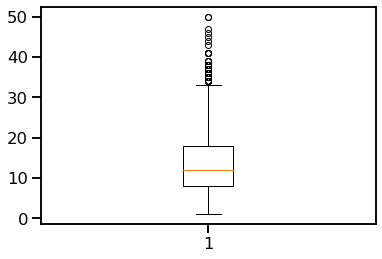

In [20]:
plt.boxplot(lens)
plt.show()

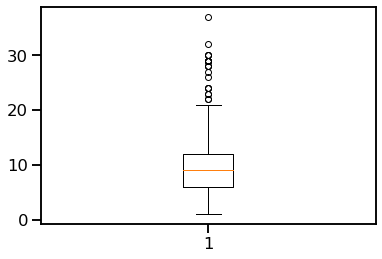

In [21]:
lens=[]
for sent in input_ids_test:
    largo=0
    for wd in sent:
        if wd!=0:
            largo+=1
    lens.append(largo)
    
plt.boxplot(lens)
plt.show()

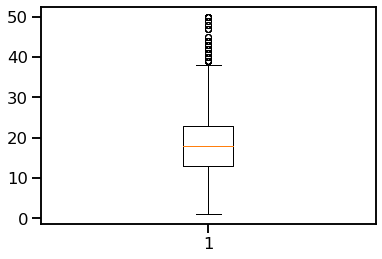

In [23]:
etiq=[d_lab[y] for y in train['Label']]
n_labels_train = np.array(etiq)
y_train=to_categorical(n_labels_train,num_classes=4)
sentences_train = train['Tweet'].values
input_ids_train = []
for sent in sentences_train:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_train.append(encoded_sent)
input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

lens=[]
for sent in input_ids_train:
    largo=0
    for wd in sent:
        if wd!=0:
            largo+=1
    lens.append(largo)
    
plt.boxplot(lens)
plt.show()

shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 768))
i=0
for in_id in input_ids_val:
    x_val[i]=M_BERT_space[in_id]
    i+=1
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 768))
i=0
for in_id in input_ids_test:
    x_test[i]=M_BERT_space[in_id]
    i+=1

x_test.shape


In [10]:
x_val.shape

(2125, 768)

In [9]:
#SMOTE

shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], 768))
i=0
for in_id in input_ids_val:
    vector=np.zeros(768)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=M_BERT_space[idv]
    x_val[i]=(vector/n)
    i+=1  

shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], 768))
i=0
for in_id in input_ids_test:
    vector=np.zeros(768)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=M_BERT_space[idv]
    x_test[i]=(vector/n)
    i+=1  


In [10]:
np.sum(y_val[:,2])

36.0

In [11]:
np.sum(val['Label']=='PhysicalH')

36

### Bias de agregar varias veces a lo mendoza 0.15

In [13]:
prob= 0.15
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

print (aum_weight)

for i in range(5): 
    macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    
    np.save('../Data_augmented/Harassment_agregado/Aumento_'+str(i+1)+'-run_'+str(prob)+'_balanced_w4_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.15/cnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.15/cnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.15/rnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.15/rnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines_harass/0.15/rnn3_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


{'SexualH': 1079, 'NonH': 0, 'PhysicalH': 3585, 'IndirectH': 3606}
--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15
--------------------------------------------------------

Generando 1079 nuevos ejemplos para la clase SexualH
# terms modificados promedio 1.9499536607970342 términos por sentencia
Largo de sentencia promedio 20.06024096385542 términos por sentencia
para esta ejecución se debiesen reemplazar 2234  de 15251 terminos
Resumen de modificaciones: {'NN': 1697, 'JJ': 120, 'NNS': 133, 'VBG': 50, 'VBZ': 6, 'VB': 50, 'VBN': 35, 'VBD': 10, 'JJS': 3}
Este proceso tomó 20.714561223983765 seg

Generando 0 nuevos ejemplos para la clase NonH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 1.2722406387329102 seg

Generando 3585 nuevos ejemplos para la clase PhysicalH
# terms modificados promedio 1.8708507670850767 términos por sentencia
Largo de sentencia promedio 17.14142259414226 términos por sentencia


# terms modificados promedio 1.8465829846582984 términos por sentencia
Largo de sentencia promedio 17.095955369595536 términos por sentencia
para esta ejecución se debiesen reemplazar 7067  de 47175 terminos
Resumen de modificaciones: {'JJ': 385, 'NN': 5077, 'VBN': 135, 'VBZ': 52, 'VBG': 257, 'NNS': 400, 'VB': 210, 'VBD': 104}
Este proceso tomó 35.14135193824768 seg

Generando 3606 nuevos ejemplos para la clase IndirectH
# terms modificados promedio 1.7800887409872435 términos por sentencia
Largo de sentencia promedio 17.189129229062672 términos por sentencia
para esta ejecución se debiesen reemplazar 6693  de 43877 terminos
Resumen de modificaciones: {'VBG': 255, 'NN': 4683, 'JJ': 422, 'VB': 156, 'NNS': 525, 'VBZ': 37, 'VBN': 234, 'VBD': 107}
Este proceso tomó 33.815747022628784 seg
Pesos de clases: [0.9962442  1.01143927 0.9962442  0.9962442 ]

Accuracy sobre Train cnn1 : 0.9923915278634587
F1-score None sobre Train cnn1 : [0.98533075 0.9995842  0.99918122 0.98555811]
F1-score macro 

No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 1.2925524711608887 seg

Generando 3585 nuevos ejemplos para la clase PhysicalH
# terms modificados promedio 1.8527196652719666 términos por sentencia
Largo de sentencia promedio 17.129149232914923 términos por sentencia
para esta ejecución se debiesen reemplazar 7078  de 47688 terminos
Resumen de modificaciones: {'NN': 5104, 'VBG': 253, 'VBN': 159, 'JJ': 382, 'VBZ': 53, 'NNS': 390, 'VB': 215, 'VBD': 86}
Este proceso tomó 35.279247522354126 seg

Generando 3606 nuevos ejemplos para la clase IndirectH
# terms modificados promedio 1.7781475318912923 términos por sentencia
Largo de sentencia promedio 17.29034941763727 términos por sentencia
para esta ejecución se debiesen reemplazar 6703  de 44458 terminos
Resumen de modificaciones: {'VBG': 244, 'NN': 4690, 'JJ': 381, 'VBN': 219, 'NNS': 560, 'VB': 163, 'VBD': 102, 'VBZ': 53}
Este proceso tomó 33.72319746017456 seg
Pesos de clases: [1. 1. 1. 1.]

Accuracy sobre Train cnn1

In [14]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.15) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.15) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.15) app1 Accuracy promedio para",key,":" ,temp/5)

(0.15) app1 F1-score promedio para cnn1 : [0.90608157 0.00363636 0.02051451 0.68411122]
(0.15) app1 F1-score promedio para cnn2 : [0.90567582 0.00730731 0.01025641 0.66688491]
(0.15) app1 F1-score promedio para rnn1 : [0.87093808 0.1114497  0.08921368 0.60319616]
(0.15) app1 F1-score promedio para rnn2 : [0.87792246 0.07836899 0.06278359 0.60818449]
(0.15) app1 F1-score promedio para rnn3 : [0.83610211 0.0784687  0.05816854 0.6069777 ]

(0.15) app1 F1-score macro promedio para cnn1 : 0.403585912823504 desvest:  0.006977489251846162
(0.15) app1 F1-score macro promedio para cnn2 : 0.3975311115881673 desvest:  0.014604542928763517
(0.15) app1 F1-score macro promedio para rnn1 : 0.41869940386540955 desvest:  0.02081345799383976
(0.15) app1 F1-score macro promedio para rnn2 : 0.40681488030274915 desvest:  0.01031956607173207
(0.15) app1 F1-score macro promedio para rnn3 : 0.3949292620643767 desvest:  0.045334822720221615

(0.15) app1 Accuracy promedio para cnn1 : 0.8369288742345737
(0.15) a

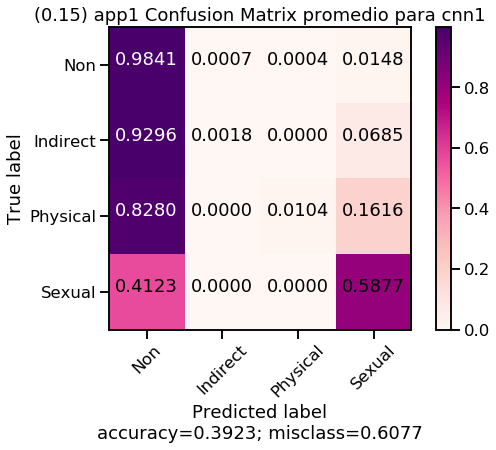

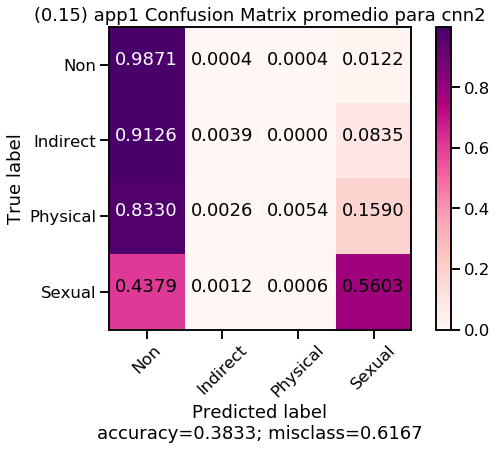

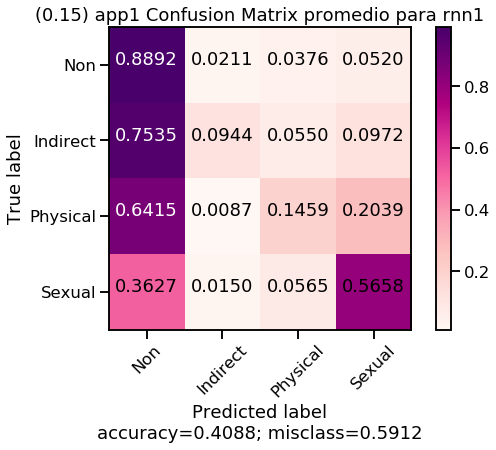

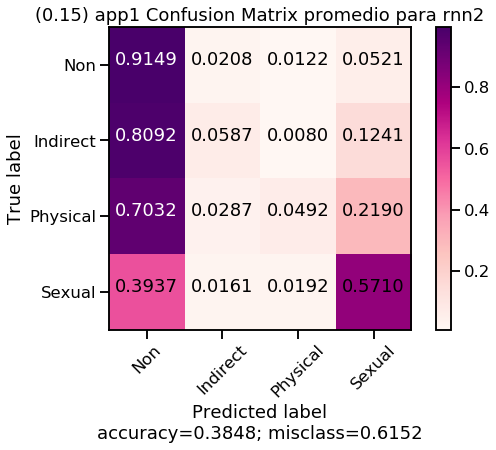

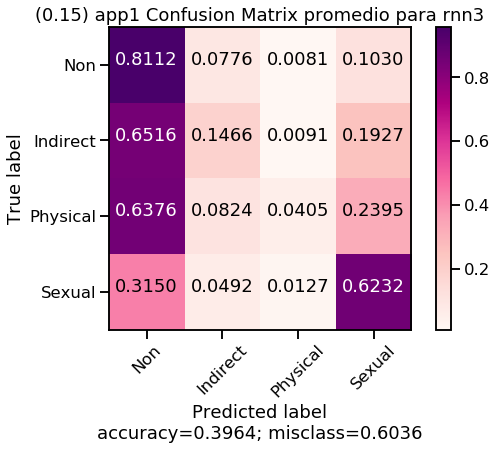

In [16]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['Non','Indirect','Physical','Sexual'], "(0.15) app1 Confusion Matrix promedio para "+str(key), cmap='RdPu')

### Masking 0.85

In [17]:
prob= 0.85
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(5): 
    macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    
    np.save('../Data_augmented/Harassment_agregado/Aumento_'+str(i+1)+'-run_'+str(prob)+'_balanced_w4_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.85/cnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.85/cnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.85/rnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.85/rnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines_harass/0.85/rnn3_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)
    

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85
--------------------------------------------------------

Generando 1079 nuevos ejemplos para la clase SexualH
# terms modificados promedio 8.68303985171455 términos por sentencia
Largo de sentencia promedio 19.231696014828543 términos por sentencia
para esta ejecución se debiesen reemplazar 9995  de 11760 terminos
Resumen de modificaciones: {'NN': 7315, 'JJ': 687, 'NNS': 626, 'VB': 197, 'VBG': 273, 'VBN': 151, 'VBD': 49, 'VBZ': 47, 'JJS': 18, 'VBP': 2, 'JJR': 4}
Este proceso tomó 73.43008160591125 seg

Generando 0 nuevos ejemplos para la clase NonH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 1.274834394454956 seg

Generando 3585 nuevos ejemplos para la clase PhysicalH
# terms modificados promedio 8.042119944211995 términos por sentencia
Largo de sentencia promedio 16.65299860529986 términos por sentencia
para esta ejecución se debiesen reemplazar 308


Accuracy sobre Val rnn3 : 0.7345882352941177
F1-score None sobre Val rnn3 : [0.81129944 0.         0.07894737 0.66436464]
F1-score macro sobre Val rnn3 : 0.38865286108331976

Accuracy sobre Test rnn3 : 0.6509656146961846
F1-score None sobre Test rnn3 : [0.77293659 0.01851852 0.07518797 0.4822335 ]
F1-score macro sobre Test rnn3 : 0.3372191458147801
--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85
--------------------------------------------------------

Generando 1079 nuevos ejemplos para la clase SexualH
# terms modificados promedio 8.695088044485635 términos por sentencia
Largo de sentencia promedio 19.231696014828543 términos por sentencia
para esta ejecución se debiesen reemplazar 9976  de 11760 terminos
Resumen de modificaciones: {'NN': 7327, 'JJ': 676, 'NNS': 616, 'VBG': 278, 'VB': 204, 'VBZ': 48, 'VBN': 152, 'VBD': 56, 'JJS': 20, 'VBP': 1, 'JJR': 4}
Este proceso tomó 74.53393054008484 seg

Generando 0 nuevos ejemplos 


Accuracy sobre Test rnn2 : 0.7178520960904381
F1-score None sobre Test rnn2 : [0.83970407 0.17699115 0.07352941 0.48197343]
F1-score macro sobre Test rnn2 : 0.39304951644821073

Accuracy sobre Train rnn3 : 0.9836110352362742
F1-score None sobre Train rnn3 : [0.98240754 0.9974118  0.98319678 0.97170187]
F1-score macro sobre Train rnn3 : 0.9836794959773048

Accuracy sobre Val rnn3 : 0.8117647058823529
F1-score None sobre Val rnn3 : [0.87798036 0.1147541  0.05263158 0.75121163]
F1-score macro sobre Val rnn3 : 0.44914441840709496

Accuracy sobre Test rnn3 : 0.7626000942063118
F1-score None sobre Test rnn3 : [0.85869913 0.14906832 0.         0.60135135]
F1-score macro sobre Test rnn3 : 0.4022797023063451
--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85
--------------------------------------------------------

Generando 1079 nuevos ejemplos para la clase SexualH
# terms modificados promedio 8.607970342910102 términos por sentencia

In [18]:
for key in fs_none.keys():
    print (key)
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.85) app1 F1-score promedio para",key,":" ,temp/5)
    
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.85) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))


for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.85) app1 Accuracy promedio para",key,":" ,temp/5)

cnn1
(0.85) app1 F1-score promedio para cnn1 : [0.89389347 0.05652388 0.00519481 0.63239577]
cnn2
(0.85) app1 F1-score promedio para cnn2 : [0.90113785 0.0482736  0.02000475 0.6464844 ]
rnn1
(0.85) app1 F1-score promedio para rnn1 : [0.8798811  0.06948132 0.03586591 0.57511826]
rnn2
(0.85) app1 F1-score promedio para rnn2 : [0.85684058 0.05590445 0.02374572 0.53658141]
rnn3
(0.85) app1 F1-score promedio para rnn3 : [0.83641678 0.09573944 0.045734   0.56358144]
(0.85) app1 F1-score macro promedio para cnn1 : 0.3970019804919124 desvest:  0.005924593248108104
(0.85) app1 F1-score macro promedio para cnn2 : 0.40397515043187593 desvest:  0.006445264959832038
(0.85) app1 F1-score macro promedio para rnn1 : 0.3900866477058099 desvest:  0.031549863615330305
(0.85) app1 F1-score macro promedio para rnn2 : 0.3682680377928736 desvest:  0.019205752244487947
(0.85) app1 F1-score macro promedio para rnn3 : 0.3853679148588056 desvest:  0.024858424628719258
(0.85) app1 Accuracy promedio para cnn1 : 0.

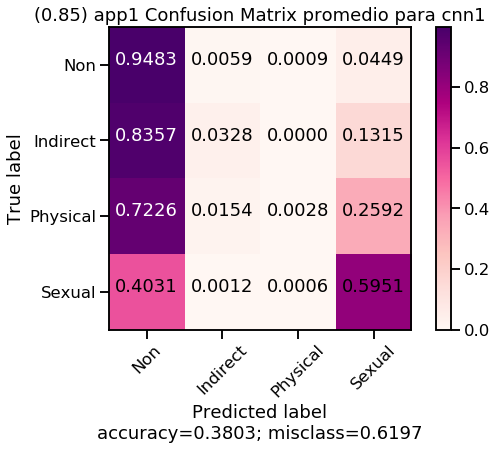

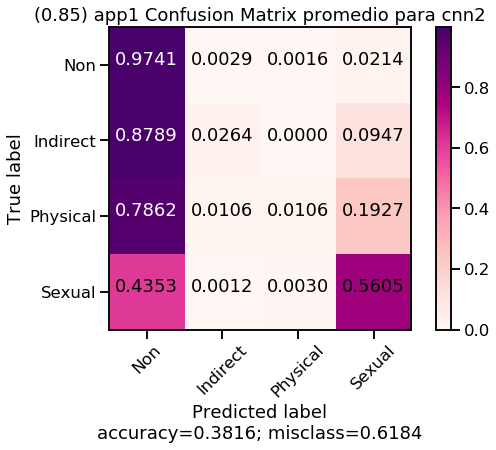

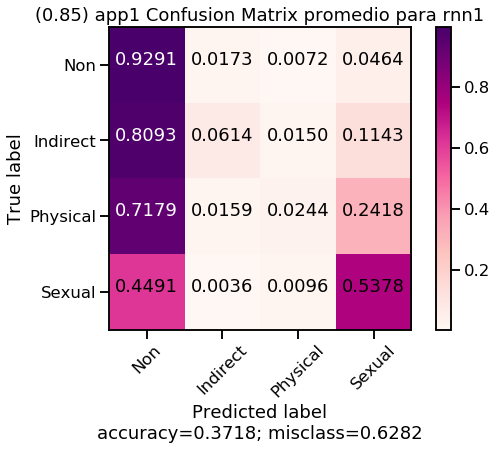

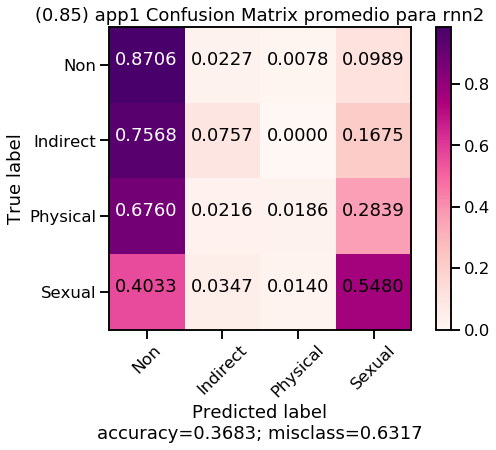

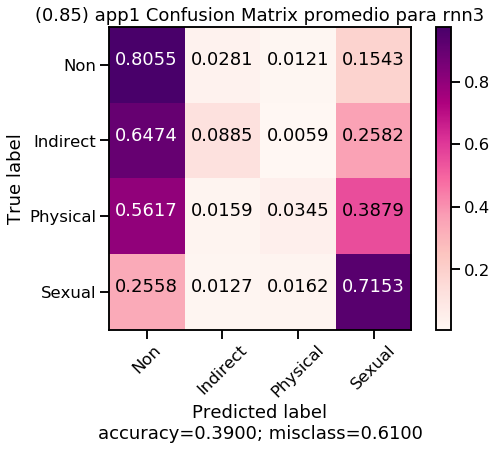

In [19]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['Non','Indirect','Physical','Sexual'], "(0.85) app1 Confusion Matrix promedio para "+str(key), cmap='RdPu')

macro_augmented = np.load('../Data_augmented/Stance_agregado/Aumento_1-run_'+str(0.85)+'_balanced_w4_app1_Top'+str(1)+'.npy', allow_pickle=True)
ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]


input_ids = []
for sent in tws_train:
    encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
    input_ids.append(encoded_sent)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

## App 1 masking 0.5

In [21]:
prob= 0.5
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(5): 
    macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    
    np.save('../Data_augmented/Harassment_agregado/Aumento_'+str(i+1)+'-run_'+str(prob)+'_balanced_w4_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.5/cnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.5/cnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.5/rnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.5/rnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines_harass/0.5/rnn3_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5
--------------------------------------------------------

Generando 1079 nuevos ejemplos para la clase SexualH
# terms modificados promedio 5.159406858202039 términos por sentencia
Largo de sentencia promedio 19.296570898980537 términos por sentencia
para esta ejecución se debiesen reemplazar 5936  de 11862 terminos
Resumen de modificaciones: {'NN': 4350, 'NNS': 386, 'JJ': 387, 'VBG': 161, 'VB': 119, 'VBZ': 27, 'VBN': 88, 'JJS': 13, 'VBD': 30, 'VBP': 2, 'JJR': 4}
Este proceso tomó 45.20933508872986 seg

Generando 0 nuevos ejemplos para la clase NonH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 1.2937791347503662 seg

Generando 3585 nuevos ejemplos para la clase PhysicalH
# terms modificados promedio 4.763737796373779 términos por sentencia
Largo de sentencia promedio 16.687587168758718 términos por sentencia
para esta ejecución se debiesen reemplazar 18


Accuracy sobre Val rnn3 : 0.8315294117647059
F1-score None sobre Val rnn3 : [0.89663684 0.04301075 0.04878049 0.71085714]
F1-score macro sobre Val rnn3 : 0.4248213059578815

Accuracy sobre Test rnn3 : 0.8012246820536976
F1-score None sobre Test rnn3 : [0.88476672 0.06779661 0.         0.49797571]
F1-score macro sobre Test rnn3 : 0.3626347603873843
--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5
--------------------------------------------------------

Generando 1079 nuevos ejemplos para la clase SexualH
# terms modificados promedio 5.168674698795181 términos por sentencia
Largo de sentencia promedio 19.2548656163114 términos por sentencia
para esta ejecución se debiesen reemplazar 5957  de 11818 terminos
Resumen de modificaciones: {'NN': 4364, 'JJ': 427, 'NNS': 351, 'VB': 116, 'VBG': 171, 'VBN': 81, 'VBD': 26, 'VBZ': 27, 'JJS': 10, 'VBP': 1, 'JJR': 3}
Este proceso tomó 45.92603826522827 seg

Generando 0 nuevos ejemplos para 


Accuracy sobre Test rnn2 : 0.6806406029203956
F1-score None sobre Test rnn2 : [0.7990298  0.0516129  0.02197802 0.51526032]
F1-score macro sobre Test rnn2 : 0.346970261848353

Accuracy sobre Train rnn3 : 0.995697896749522
F1-score None sobre Train rnn3 : [0.99176729 0.99959044 0.99945355 0.99197825]
F1-score macro sobre Train rnn3 : 0.9956973825958532

Accuracy sobre Val rnn3 : 0.8705882352941177
F1-score None sobre Val rnn3 : [0.9206762  0.02739726 0.08888889 0.81628788]
F1-score macro sobre Val rnn3 : 0.4633125577028996

Accuracy sobre Test rnn3 : 0.8214790390956194
F1-score None sobre Test rnn3 : [0.9        0.03448276 0.04545455 0.65420561]
F1-score macro sobre Test rnn3 : 0.40853572788796766
--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5
--------------------------------------------------------

Generando 1079 nuevos ejemplos para la clase SexualH
# terms modificados promedio 5.089898053753475 términos por sentencia
Lar

In [22]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.5) app1 F1-score promedio para",key,":" ,temp/5)
    
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.5) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.5) app1 Accuracy promedio para",key,":" ,temp/5)

(0.5) app1 F1-score promedio para cnn1 : [0.90631774 0.03730169 0.03031646 0.69079226]
(0.5) app1 F1-score promedio para cnn2 : [0.90461766 0.04255571 0.01519468 0.67013684]
(0.5) app1 F1-score promedio para rnn1 : [0.86933175 0.1126781  0.08301551 0.59797319]
(0.5) app1 F1-score promedio para rnn2 : [0.80457899 0.05598996 0.02385506 0.52177443]
(0.5) app1 F1-score promedio para rnn3 : [0.8702928  0.03109074 0.06625193 0.57929176]
(0.5) app1 F1-score macro promedio para cnn1 : 0.41618203528440956 desvest:  0.013837501145379972
(0.5) app1 F1-score macro promedio para cnn2 : 0.40812622341881843 desvest:  0.0019936729684899034
(0.5) app1 F1-score macro promedio para rnn1 : 0.4157496387616028 desvest:  0.010904455237654988
(0.5) app1 F1-score macro promedio para rnn2 : 0.35154961197325274 desvest:  0.026821022375093376
(0.5) app1 F1-score macro promedio para rnn3 : 0.38673180867840695 desvest:  0.020173349502660566
(0.5) app1 Accuracy promedio para cnn1 : 0.8351389543099387
(0.5) app1 Accu

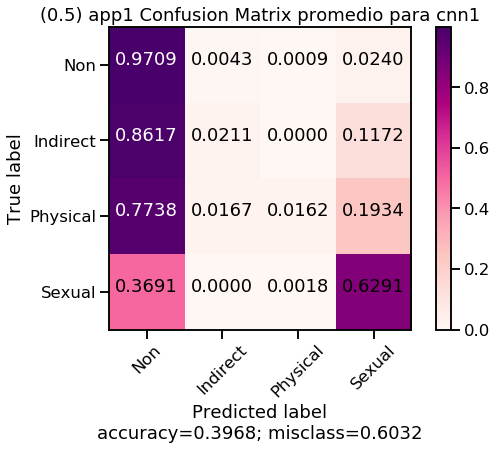

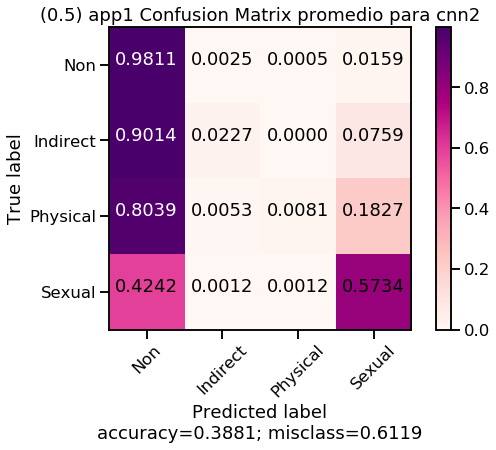

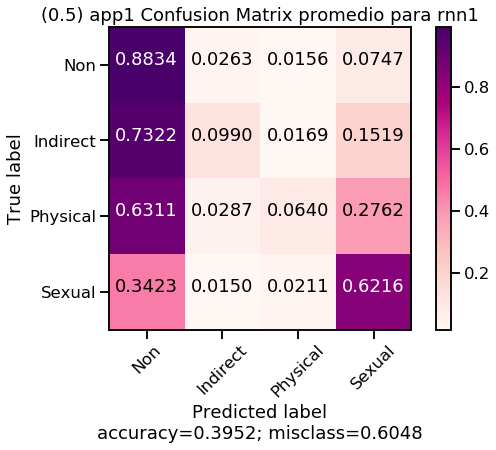

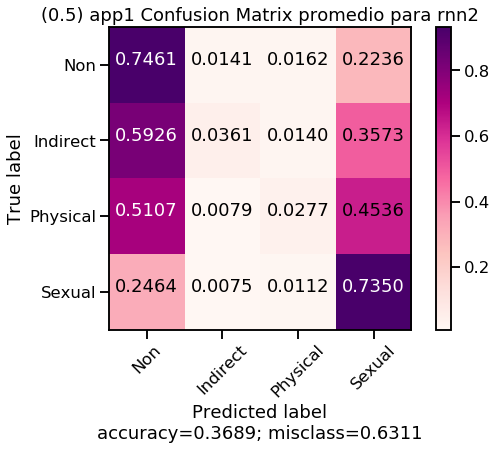

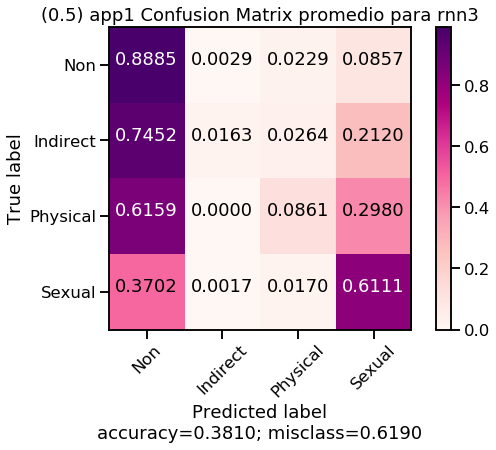

In [23]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['Non','Indirect','Physical','Sexual'], "(0.5) app1 Confusion Matrix promedio para "+str(key), cmap='RdPu')

## Sin Data augmentation sin CW

In [35]:
prob= 0.0
TOPN = 1

fs_macro_wo={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none_wo={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs_wo={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions_wo={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight = {'NonH': 0, 'IndirectH': 0, 'PhysicalH': 0, 'SexualH': 0}

for i in range(5): 
    macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    
    np.save('../Data_augmented/Harassment_agregado/Sin_Aumento_'+str(i+1)+'-run_'+str(prob)+'_balanced_w4_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= [1.0, 1.0, 1.0, 1.0] #compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1
######################################################################

    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.0_wo/cnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro_wo['cnn1'].append(f1_ma_t)
    fs_none_wo['cnn1'].append(f1_t)
    accs_wo['cnn1'].append(acc_t)
    confusions_wo['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.0_wo/cnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro_wo['cnn2'].append(f1_ma_t)
    fs_none_wo['cnn2'].append(f1_t)
    accs_wo['cnn2'].append(acc_t)
    confusions_wo['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.0_wo/rnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro_wo['rnn1'].append(f1_ma_t)
    fs_none_wo['rnn1'].append(f1_t)
    accs_wo['rnn1'].append(acc_t)
    confusions_wo['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.0_wo/rnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro_wo['rnn2'].append(f1_ma_t)
    fs_none_wo['rnn2'].append(f1_t)
    accs_wo['rnn2'].append(acc_t)
    confusions_wo['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines_harass/0.0_wo/rnn3_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro_wo['rnn3'].append(f1_ma_t)
    fs_none_wo['rnn3'].append(f1_t)
    accs_wo['rnn3'].append(acc_t)
    confusions_wo['rnn3'].append(matriz_t)

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.0
--------------------------------------------------------

Generando 0 nuevos ejemplos para la clase NonH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 1.2197630405426025 seg

Generando 0 nuevos ejemplos para la clase IndirectH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.019789695739746094 seg

Generando 0 nuevos ejemplos para la clase PhysicalH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.02678966522216797 seg

Generando 0 nuevos ejemplos para la clase SexualH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.8755111694335938 seg
Pesos de clases: [1.0, 1.0, 1.0, 1.0]

Accuracy sobre Train cnn1 : 0.9727016002510198
F1-score None sobre Train cnn1 : [0.97731287 0.9245283  0.90140845 0.96906013]
F1-score macro sobre Train cnn1 : 0.943077436530131

Accuracy sobre Val cnn1 : 0.8818


Accuracy sobre Train cnn2 : 0.9747411358644493
F1-score None sobre Train cnn2 : [0.97918401 0.91588785 0.93877551 0.97087746]
F1-score macro sobre Train cnn2 : 0.951181208097493

Accuracy sobre Val cnn2 : 0.8894117647058823
F1-score None sobre Val cnn2 : [0.93251136 0.         0.05128205 0.85444234]
F1-score macro sobre Val cnn2 : 0.4595589378973969

Accuracy sobre Test cnn2 : 0.8417333961375412
F1-score None sobre Test cnn2 : [0.90872675 0.         0.         0.69947276]
F1-score macro sobre Test cnn2 : 0.4020498779325725

Accuracy sobre Train rnn1 : 0.973642924380295
F1-score None sobre Train rnn1 : [0.98062921 0.70344828 0.84269663 0.97590361]
F1-score macro sobre Train rnn1 : 0.8756694317105199

Accuracy sobre Val rnn1 : 0.8536470588235294
F1-score None sobre Val rnn1 : [0.91123485 0.09174312 0.06451613 0.81091618]
F1-score macro sobre Val rnn1 : 0.46960256965045194

Accuracy sobre Test rnn1 : 0.8130004710315591
F1-score None sobre Test rnn1 : [0.89451974 0.20540541 0.12727273 0.6


Accuracy sobre Test rnn2 : 0.8257183231276496
F1-score None sobre Test rnn2 : [0.90252708 0.01470588 0.14159292 0.72511144]
F1-score macro sobre Test rnn2 : 0.44598432995669396

Accuracy sobre Train rnn3 : 0.867587072481958
F1-score None sobre Train rnn3 : [0.97265993 0.33544304 0.04240283 0.83494708]
F1-score macro sobre Train rnn3 : 0.546363220369958

Accuracy sobre Val rnn3 : 0.7976470588235294
F1-score None sobre Val rnn3 : [0.91412214 0.04968944 0.04511278 0.6182266 ]
F1-score macro sobre Val rnn3 : 0.40678774033461945

Accuracy sobre Test rnn3 : 0.7875647668393783
F1-score None sobre Test rnn3 : [0.89611511 0.06936416 0.04511278 0.45591398]
F1-score macro sobre Test rnn3 : 0.36662650755322274


In [36]:
for key in fs_none_wo.keys():
    temp=np.zeros(4)
    for result in fs_none_wo[key]:
        temp+=result
    print ("(0.0) app1 F1-score promedio para",key,":" ,temp/5)
    
print ("")
for key in fs_macro_wo.keys():
    temp=np.sum(fs_macro_wo[key])
    print ("(0.0) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro_wo[key]))

print ("")
for key in accs_wo.keys():
    temp=np.sum(accs_wo[key])
    print ("(0.0) app1 Accuracy promedio para",key,":" ,temp/5)

(0.0) app1 F1-score promedio para cnn1 : [0.90596112 0.         0.         0.68209793]
(0.0) app1 F1-score promedio para cnn2 : [0.90563943 0.         0.         0.67299234]
(0.0) app1 F1-score promedio para rnn1 : [0.88832209 0.11718637 0.0868365  0.60469162]
(0.0) app1 F1-score promedio para rnn2 : [0.89680364 0.03998145 0.06275383 0.69827288]
(0.0) app1 F1-score promedio para rnn3 : [0.8977923  0.05110251 0.05636781 0.61641088]

(0.0) app1 F1-score macro promedio para cnn1 : 0.39701476046407 desvest:  0.01132909592171182
(0.0) app1 F1-score macro promedio para cnn2 : 0.3946579417939224 desvest:  0.014058668590487114
(0.0) app1 F1-score macro promedio para rnn1 : 0.42425914536612375 desvest:  0.04111682975754262
(0.0) app1 F1-score macro promedio para rnn2 : 0.42445295242642267 desvest:  0.011336039785238061
(0.0) app1 F1-score macro promedio para rnn3 : 0.40541837532437486 desvest:  0.03376613107394492

(0.0) app1 Accuracy promedio para cnn1 : 0.8381535562882713
(0.0) app1 Accuracy 

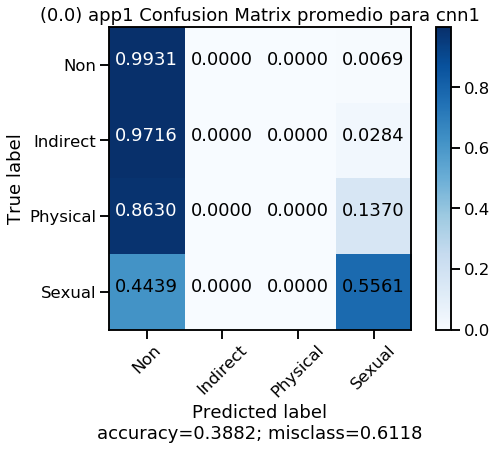

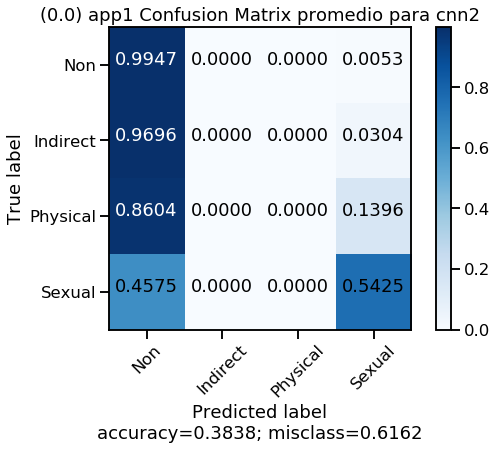

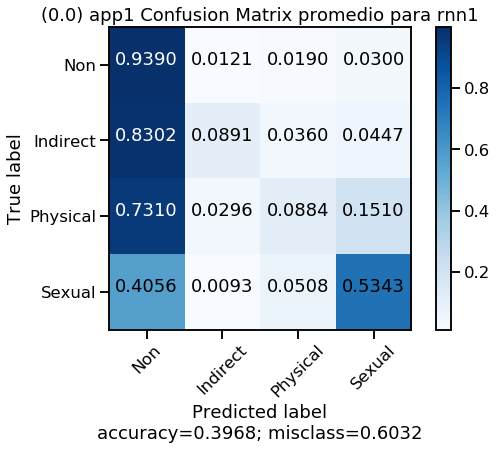

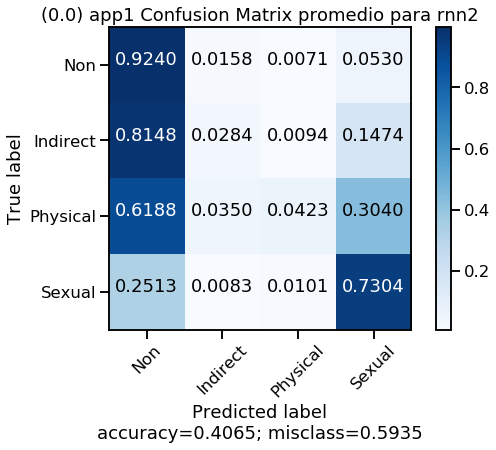

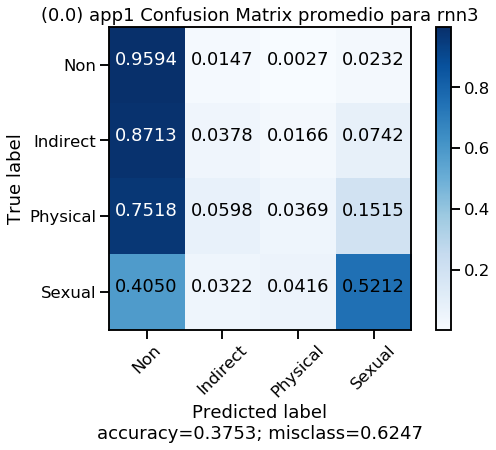

In [37]:
for key in confusions_wo.keys():
    temp=np.sum(confusions_wo[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['Non','Indirect','Physical','Sexual'], "(0.0) app1 Confusion Matrix promedio para "+str(key))

#### Nota

Redes convolucionales tienen mal desempeño en data desbalanceada

## Sin Data augmentation Con CW¶

In [29]:
prob= 0.0
TOPN = 1

fs_macro_cw={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none_cw={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs_cw={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions_cw={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight = {'NonH': 0, 'IndirectH': 0, 'PhysicalH': 0, 'SexualH': 0}

for i in range(5): 
    macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    
    np.save('../Data_augmented/Harassment_agregado/Sin_Aumento_CW_'+str(i+1)+'-run_'+str(prob)+'_balanced_w4_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1

    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.0/cnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro_cw['cnn1'].append(f1_ma_t)
    fs_none_cw['cnn1'].append(f1_t)
    accs_cw['cnn1'].append(acc_t)
    confusions_cw['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.0/cnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro_cw['cnn2'].append(f1_ma_t)
    fs_none_cw['cnn2'].append(f1_t)
    accs_cw['cnn2'].append(acc_t)
    confusions_cw['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.0/rnn1_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro_cw['rnn1'].append(f1_ma_t)
    fs_none_cw['rnn1'].append(f1_t)
    accs_cw['rnn1'].append(acc_t)
    confusions_cw['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/0.0/rnn2_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro_cw['rnn2'].append(f1_ma_t)
    fs_none_cw['rnn2'].append(f1_t)
    accs_cw['rnn2'].append(acc_t)
    confusions_cw['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines_harass/0.0/rnn3_'+str(i+1)+'-exec_w4_app1_Top_'+str(prob)+'_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro_cw['rnn3'].append(f1_ma_t)
    fs_none_cw['rnn3'].append(f1_t)
    accs_cw['rnn3'].append(acc_t)
    confusions_cw['rnn3'].append(matriz_t)

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.0
--------------------------------------------------------

Generando 0 nuevos ejemplos para la clase NonH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 1.221923828125 seg

Generando 0 nuevos ejemplos para la clase IndirectH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.018862485885620117 seg

Generando 0 nuevos ejemplos para la clase PhysicalH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.02699422836303711 seg

Generando 0 nuevos ejemplos para la clase SexualH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.8669030666351318 seg
Pesos de clases: [ 0.43526359 28.97272727 20.96710526  0.61715724]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the sam


Accuracy sobre Test cnn2 : 0.8177107866227037
F1-score None sobre Test cnn2 : [0.89581578 0.01851852 0.05063291 0.55421687]
F1-score macro sobre Test cnn2 : 0.3797960198661219

Accuracy sobre Train rnn1 : 0.7154063382491371
F1-score None sobre Train rnn1 : [0.87822118 0.28132992 0.11480363 0.68222537]
F1-score macro sobre Train rnn1 : 0.4891450222824134

Accuracy sobre Val rnn1 : 0.7072941176470589
F1-score None sobre Val rnn1 : [0.87228744 0.06060606 0.04747774 0.62291169]
F1-score macro sobre Val rnn1 : 0.40082073552882824

Accuracy sobre Test rnn1 : 0.7324540744229864
F1-score None sobre Test rnn1 : [0.8715655  0.13605442 0.10600707 0.57884972]
F1-score macro sobre Test rnn1 : 0.4231191764552623

Accuracy sobre Train rnn2 : 0.6066834013178538
F1-score None sobre Train rnn2 : [0.70132548 0.14012739 0.23639191 0.598234  ]
F1-score macro sobre Train rnn2 : 0.4190196939183324

Accuracy sobre Val rnn2 : 0.5505882352941176
F1-score None sobre Val rnn2 : [0.70344828 0.07777778 0.04819277 


Accuracy sobre Val rnn3 : 0.8658823529411764
F1-score None sobre Val rnn3 : [0.92771883 0.07894737 0.1        0.83236994]
F1-score macro sobre Val rnn3 : 0.4847590358772077

Accuracy sobre Test rnn3 : 0.8162976919453604
F1-score None sobre Test rnn3 : [0.90272374 0.05357143 0.15228426 0.69463087]
F1-score macro sobre Test rnn3 : 0.45080257510565025
--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.0
--------------------------------------------------------

Generando 0 nuevos ejemplos para la clase NonH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 1.270280361175537 seg

Generando 0 nuevos ejemplos para la clase IndirectH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.019784927368164062 seg

Generando 0 nuevos ejemplos para la clase PhysicalH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.027213096618652344 seg

Generando 0 nuevos ejemplos para la clase 

In [30]:
for key in fs_none_cw.keys():
    temp=np.zeros(4)
    for result in fs_none_cw[key]:
        temp+=result
    print ("(0.0) app1 F1-score promedio para",key,":" ,temp/5)
    
print ("")
for key in fs_macro_cw.keys():
    temp=np.sum(fs_macro_cw[key])
    print ("(0.0) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro_cw[key]))

print ("")
for key in accs_cw.keys():
    temp=np.sum(accs_cw[key])
    print ("(0.0) app1 Accuracy promedio para",key,":" ,temp/5)

(0.0) app1 F1-score promedio para cnn1 : [0.90576952 0.04541351 0.03558442 0.65456284]
(0.0) app1 F1-score promedio para cnn2 : [0.89041754 0.0394435  0.05063616 0.4921186 ]
(0.0) app1 F1-score promedio para rnn1 : [0.87686045 0.14953434 0.10483057 0.68050684]
(0.0) app1 F1-score promedio para rnn2 : [0.72335889 0.11949608 0.06228667 0.57066286]
(0.0) app1 F1-score promedio para rnn3 : [0.9004657  0.03252227 0.10411899 0.68604815]

(0.0) app1 F1-score macro promedio para cnn1 : 0.41033257059530487 desvest:  0.020338196218138878
(0.0) app1 F1-score macro promedio para cnn2 : 0.36815395067255396 desvest:  0.02115540809659764
(0.0) app1 F1-score macro promedio para rnn1 : 0.4529330499000597 desvest:  0.017924178072213845
(0.0) app1 F1-score macro promedio para rnn2 : 0.3689511257131876 desvest:  0.08049589452594591
(0.0) app1 F1-score macro promedio para rnn3 : 0.43078877715368546 desvest:  0.012617104361767332

(0.0) app1 Accuracy promedio para cnn1 : 0.8346679227508244
(0.0) app1 Accura

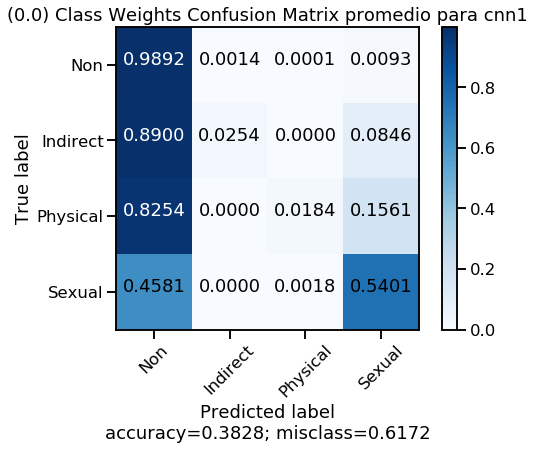

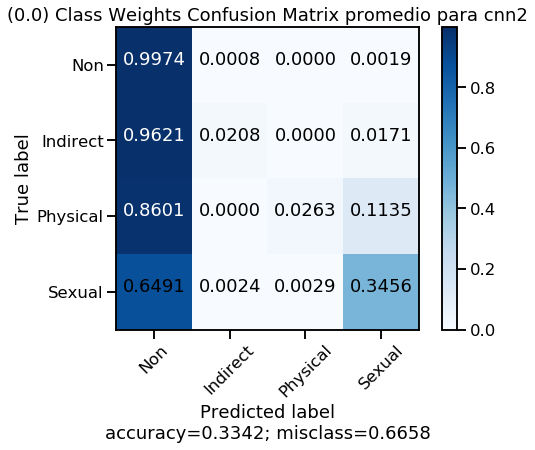

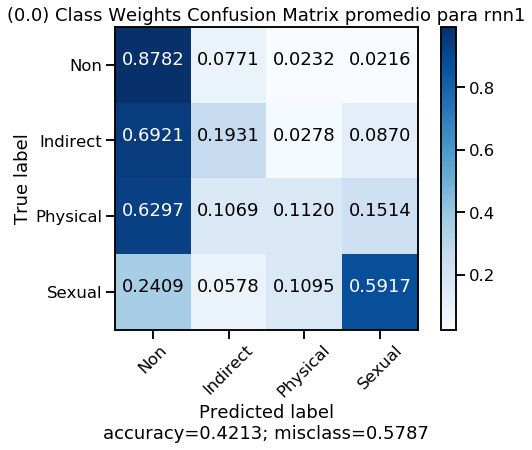

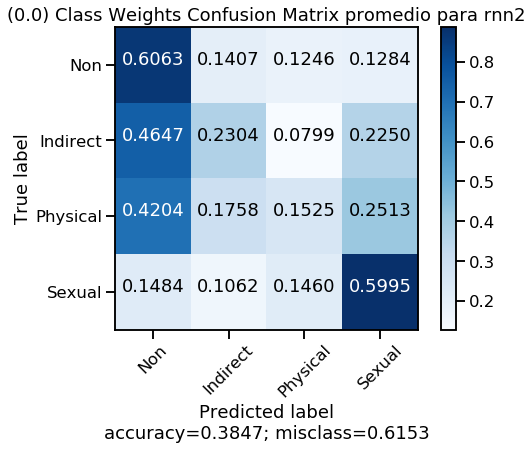

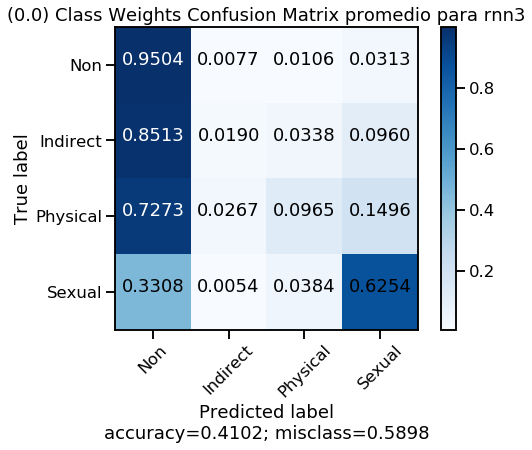

In [31]:
for key in confusions_cw.keys():
    temp=np.sum(confusions_cw[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['Non','Indirect','Physical','Sexual'], "(0.0) Class Weights Confusion Matrix promedio para "+str(key))

### Nota

La aplicación de class_weigths y focal loss para las redes recurrentes parece tener un efecto no deseado. Sin embargo las redes convolucionales se ven claramente beneficiadas por este parámetro. 

La aplicación de class_weights para una red recurrente cuya función de perdida es categorical cross entropy, no parece verse ni beneficiada ni perjudicada (no se acusan resultados significativamente diferentes)

## SMOTE Balanced 

In [12]:
from imblearn.over_sampling import SMOTE

x_val=np.expand_dims(x_val, axis=-1)
x_test=np.expand_dims(x_test, axis=-1)

In [14]:
prob= 0.0
TOPN = 1

fs_macro_sm={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none_sm={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs_sm={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions_sm={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight = {'NonH': 0, 'IndirectH': 0, 'PhysicalH': 0, 'SexualH': 0}

for i in range(5): 
    macro_augmented=[]
    print ("--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    
    np.save('../Data_augmented/Harassment_agregado/SMOTE_'+str(i+1)+'-run.npy', macro_augmented)    
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    
    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)

    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    y_train=to_categorical(n_labels, num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], 768))
    j=0
    for in_id in input_ids:
        vector=np.zeros(768)
        n = np.sum(in_id != 0)
        for idv in in_id:
            if idv!=0:
                vector+=M_BERT_space[idv]
        x_train[j]=(vector/n)
        j+=1  
     
    sm = SMOTE(random_state=27, n_jobs=-1, sampling_strategy='not majority')
    x_train, y_train = sm.fit_sample(x_train, y_train)
    etiq=np.asarray([np.argmax(y) for y in y_train])
    class_weights = compute_class_weight('balanced', np.unique(etiq), etiq)
    print ("class_weights Training set", class_weights)

    x_train=np.expand_dims(x_train, axis=-1)

    ###############################
    ###############################
    ###############################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/SMOTE/cnn1_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro_sm['cnn1'].append(f1_ma_t)
    fs_none_sm['cnn1'].append(f1_t)
    accs_sm['cnn1'].append(acc_t)
    confusions_sm['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/SMOTE/cnn2_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro_sm['cnn2'].append(f1_ma_t)
    fs_none_sm['cnn2'].append(f1_t)
    accs_sm['cnn2'].append(acc_t)
    confusions_sm['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/SMOTE/rnn1_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro_sm['rnn1'].append(f1_ma_t)
    fs_none_sm['rnn1'].append(f1_t)
    accs_sm['rnn1'].append(acc_t)
    confusions_sm['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('exec_baselines_harass/SMOTE/rnn2_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro_sm['rnn2'].append(f1_ma_t)
    fs_none_sm['rnn2'].append(f1_t)
    accs_sm['rnn2'].append(acc_t)
    confusions_sm['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('exec_baselines_harass/SMOTE/rnn3_'+str(i+1)+'-exec_w4_app1.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro_sm['rnn3'].append(f1_ma_t)
    fs_none_sm['rnn3'].append(f1_t)
    accs_sm['rnn3'].append(acc_t)
    confusions_sm['rnn3'].append(matriz_t)

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.0
--------------------------------------------------------

Generando 0 nuevos ejemplos para la clase NonH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 1.2277517318725586 seg

Generando 0 nuevos ejemplos para la clase IndirectH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.019848346710205078 seg

Generando 0 nuevos ejemplos para la clase PhysicalH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.027429580688476562 seg

Generando 0 nuevos ejemplos para la clase SexualH
No se generan ejemplos
Resumen de modificaciones: {}
Este proceso tomó 0.8674993515014648 seg
class_weights Training set [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.977465173449877
F1-score None sobre Train cnn1 : [0.95513992 0.999454   0.99836379 0.95676467]
F1-score macro sobre Train cnn1 : 0.9774305938452781

Accuracy sobre Val cnn1 : 0.


Accuracy sobre Val cnn1 : 0.8696470588235294
F1-score None sobre Val cnn1 : [0.91959961 0.         0.09756098 0.81231954]
F1-score macro sobre Val cnn1 : 0.45737003153883343

Accuracy sobre Test cnn1 : 0.8228921337729628
F1-score None sobre Test cnn1 : [0.89928264 0.         0.         0.62176166]
F1-score macro sobre Test cnn1 : 0.38026107447907764

Accuracy sobre Train cnn2 : 0.9683146681234636
F1-score None sobre Train cnn2 : [0.93601929 0.99959044 0.9980916  0.93929797]
F1-score macro sobre Train cnn2 : 0.9682498270144458

Accuracy sobre Val cnn2 : 0.8771764705882353
F1-score None sobre Val cnn2 : [0.92533333 0.02702703 0.0952381  0.83421517]
F1-score macro sobre Val cnn2 : 0.47045340578673916

Accuracy sobre Test cnn2 : 0.8290155440414507
F1-score None sobre Test cnn2 : [0.90382318 0.         0.         0.69187675]
F1-score macro sobre Test cnn2 : 0.39892498217925165

Accuracy sobre Train rnn1 : 0.642925430210325
F1-score None sobre Train rnn1 : [0.64457571 0.73028071 0.65999714 


Accuracy sobre Train rnn2 : 0.25
F1-score None sobre Train rnn2 : [0.  0.4 0.  0. ]
F1-score macro sobre Train rnn2 : 0.1

Accuracy sobre Val rnn2 : 0.033411764705882356
F1-score None sobre Val rnn2 : [0.         0.06466302 0.         0.        ]
F1-score macro sobre Val rnn2 : 0.016165755919854283

Accuracy sobre Test rnn2 : 0.04992934526613283
F1-score None sobre Test rnn2 : [0.         0.09510991 0.         0.        ]
F1-score macro sobre Test rnn2 : 0.023777478689995513

Accuracy sobre Train rnn3 : 0.41245561322043156
F1-score None sobre Train rnn3 : [0.50016584 0.19657237 0.41368019 0.40969803]
F1-score macro sobre Train rnn3 : 0.3800291061803617

Accuracy sobre Val rnn3 : 0.7124705882352941
F1-score None sobre Val rnn3 : [0.8323258  0.015625   0.         0.46015713]
F1-score macro sobre Val rnn3 : 0.32702698254909185

Accuracy sobre Test rnn3 : 0.7414036740461611
F1-score None sobre Test rnn3 : [0.85063591 0.         0.04166667 0.41294299]
F1-score macro sobre Test rnn3 : 0.326

In [15]:
for key in fs_none_sm.keys():
    temp=np.zeros(4)
    for result in fs_none_sm[key]:
        temp+=result
    print ("(SMOTE) F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro_sm.keys():
    temp=np.sum(fs_macro_sm[key])
    print ("(SMOTE) F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro_sm[key]))

print ("")
for key in accs_sm.keys():
    temp=np.sum(accs_sm[key])
    print ("(SMOTE) Accuracy promedio para",key,":" ,temp/5)

(SMOTE) F1-score promedio para cnn1 : [0.90162114 0.         0.         0.66716969]
(SMOTE) F1-score promedio para cnn2 : [0.90437738 0.0037037  0.         0.68086382]
(SMOTE) F1-score promedio para rnn1 : [0.81218403 0.0627887  0.04166693 0.22741143]
(SMOTE) F1-score promedio para rnn2 : [0.285807   0.0688132  0.02877111 0.        ]
(SMOTE) F1-score promedio para rnn3 : [0.61272124 0.0442566  0.01166667 0.17510142]

(SMOTE) F1-score macro promedio para cnn1 : 0.39219770606843635 desvest:  0.008573086888823378
(SMOTE) F1-score macro promedio para cnn2 : 0.3972362262138721 desvest:  0.006978717082348146
(SMOTE) F1-score macro promedio para rnn1 : 0.28601277120742674 desvest:  0.005102279063233321
(SMOTE) F1-score macro promedio para rnn2 : 0.09584782509938762 desvest:  0.07770563608154321
(SMOTE) F1-score macro promedio para rnn3 : 0.21093648127927275 desvest:  0.1060112875301231

(SMOTE) Accuracy promedio para cnn1 : 0.8262835609985869
(SMOTE) Accuracy promedio para cnn2 : 0.8316533207

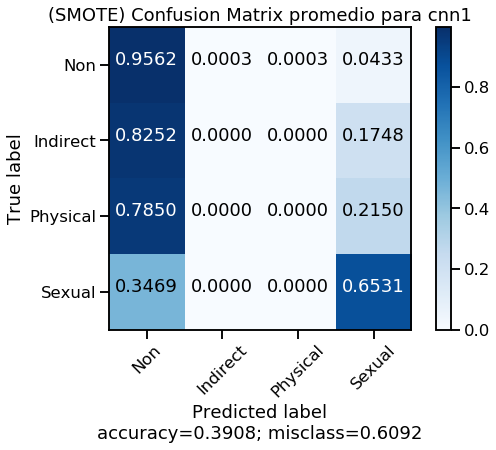

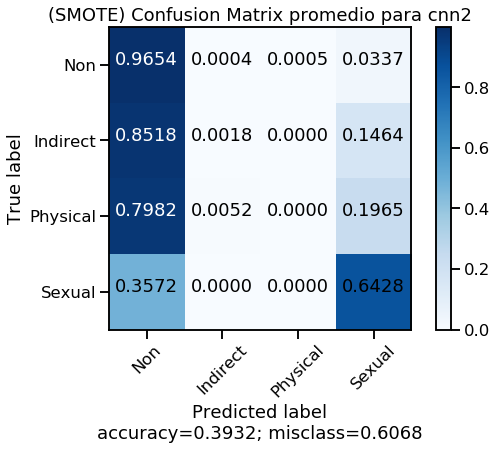

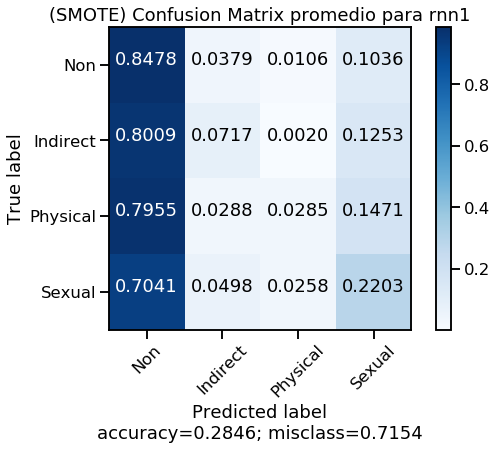

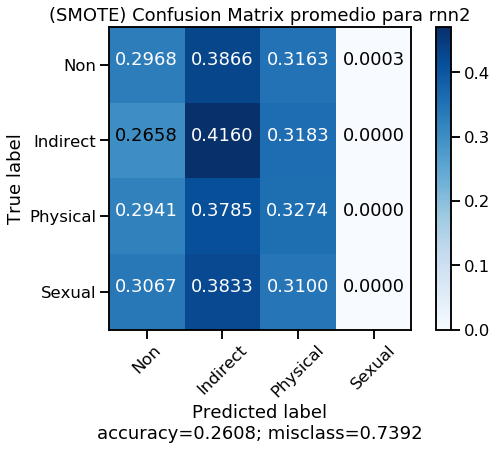

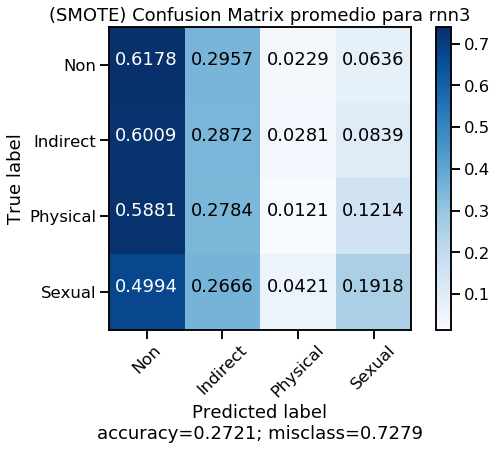

In [16]:
for key in confusions_sm.keys():
    temp=np.sum(confusions_sm[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['Non','Indirect','Physical','Sexual'], "(SMOTE) Confusion Matrix promedio para "+str(key))

## idem : prob 0.5 bias 1.0

In [7]:
for key in fs_none.keys():
    print (key)
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.5) F1-score promedio para",key,":" ,temp/5)
    
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.5) F1-score macro promedio para",key,":" ,temp/5)

for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.5) Accuracy promedio para",key,":" ,temp/5)

cnn1
(0.5) F1-score promedio para cnn1 : [0.46428476 0.10821921 0.82561897 0.11303309]
cnn2
(0.5) F1-score promedio para cnn2 : [0.46720603 0.08562853 0.81250686 0.12464111]
rnn1
(0.5) F1-score promedio para rnn1 : [0.46904705 0.12407955 0.74932445 0.13775533]
rnn2
(0.5) F1-score promedio para rnn2 : [0.45736906 0.09871454 0.74256986 0.11863561]
rnn3
(0.5) F1-score promedio para rnn3 : [0.43078368 0.077807   0.67030806 0.10989741]
(0.5) F1-score macro promedio para cnn1 : 0.3777890078517296
(0.5) F1-score macro promedio para cnn2 : 0.37249563305599975
(0.5) F1-score macro promedio para rnn1 : 0.3700515953704765
(0.5) F1-score macro promedio para rnn2 : 0.3543222697089608
(0.5) F1-score macro promedio para rnn3 : 0.32219903972213537
(0.5) Accuracy promedio para cnn1 : 0.7083251714005877
(0.5) Accuracy promedio para cnn2 : 0.6893241919686581
(0.5) Accuracy promedio para rnn1 : 0.6129285014691479
(0.5) Accuracy promedio para rnn2 : 0.6072477962781587
(0.5) Accuracy promedio para rnn3 : 0.

# bias 5.0 

In [7]:
for key in fs_none.keys():
    print (key)
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.5) F1-score promedio para",key,":" ,temp/5)
    
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.5) F1-score macro promedio para",key,":" ,temp/5)

for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.5) Accuracy promedio para",key,":" ,temp/5)

cnn1
(0.5) F1-score promedio para cnn1 : [0.50245922 0.10758113 0.8112818  0.13587583]
cnn2
(0.5) F1-score promedio para cnn2 : [0.48898438 0.05402931 0.83292933 0.13345576]
rnn1
(0.5) F1-score promedio para rnn1 : [0.42071896 0.11387385 0.77486019 0.12593881]
rnn2
(0.5) F1-score promedio para rnn2 : [0.37589998 0.08606076 0.72976988 0.14073068]
rnn3
(0.5) F1-score promedio para rnn3 : [0.40903414 0.07208558 0.78395742 0.13625779]
(0.5) F1-score macro promedio para cnn1 : 0.3892994958376172
(0.5) F1-score macro promedio para cnn2 : 0.37734969514830297
(0.5) F1-score macro promedio para rnn1 : 0.3588479505975995
(0.5) F1-score macro promedio para rnn2 : 0.3331153243637937
(0.5) F1-score macro promedio para rnn3 : 0.3503337327209119
(0.5) Accuracy promedio para cnn1 : 0.6873653281096963
(0.5) Accuracy promedio para cnn2 : 0.7190989226248775
(0.5) Accuracy promedio para rnn1 : 0.6409402546523018
(0.5) Accuracy promedio para rnn2 : 0.5884427032321253
(0.5) Accuracy promedio para rnn3 : 0.6

# Last modif  bias 3.0

In [7]:
for key in fs_none.keys():
    print (key)
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.5) F1-score promedio para",key,":" ,temp/5)
    
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.5) F1-score macro promedio para",key,":" ,temp/5)

for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.5) Accuracy promedio para",key,":" ,temp/5)

cnn1
(0.5) F1-score promedio para cnn1 : [0.51822021 0.05836302 0.83332106 0.1070645 ]
cnn2
(0.5) F1-score promedio para cnn2 : [0.40913469 0.0734471  0.82162238 0.11649137]
rnn1
(0.5) F1-score promedio para rnn1 : [0.45361572 0.05706124 0.80289107 0.12832302]
rnn2
(0.5) F1-score promedio para rnn2 : [0.44530906 0.11197197 0.6796401  0.16103357]
rnn3
(0.5) F1-score promedio para rnn3 : [0.39350307 0.10293988 0.74571147 0.14819499]
(0.5) F1-score macro promedio para cnn1 : 0.37924219698308037
(0.5) F1-score macro promedio para cnn2 : 0.35517388748583384
(0.5) F1-score macro promedio para rnn1 : 0.3604727641447064
(0.5) F1-score macro promedio para rnn2 : 0.34948867730731203
(0.5) F1-score macro promedio para rnn3 : 0.347587354948342
(0.5) Accuracy promedio para cnn1 : 0.7212536728697356
(0.5) Accuracy promedio para cnn2 : 0.7010773751224291
(0.5) Accuracy promedio para rnn1 : 0.6797257590597454
(0.5) Accuracy promedio para rnn2 : 0.5441723800195887
(0.5) Accuracy promedio para rnn3 : 0.

#### primera ejecucion de bias 3

In [7]:
for key in fs_none.keys():
    print (key)
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.5) F1-score promedio para",key,":" ,temp/5)
    
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.5) F1-score macro promedio para",key,":" ,temp/5)

for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.5) Accuracy promedio para",key,":" ,temp/5)

cnn1
(0.5) F1-score promedio para cnn1 : [0.50761628 0.06233605 0.83270211 0.1213438 ]
cnn2
(0.5) F1-score promedio para cnn2 : [0.53190881 0.05011675 0.83274412 0.15036912]
rnn1
(0.5) F1-score promedio para rnn1 : [0.44203637 0.07904874 0.83923434 0.15574569]
rnn2
(0.5) F1-score promedio para rnn2 : [0.41068698 0.03296424 0.82861729 0.10171124]
rnn3
(0.5) F1-score promedio para rnn3 : [0.42091252 0.07447959 0.73855393 0.12387645]
(0.5) F1-score macro promedio para cnn1 : 0.3809995608743424
(0.5) F1-score macro promedio para cnn2 : 0.39128470006934774
(0.5) F1-score macro promedio para rnn1 : 0.37901628881330857
(0.5) F1-score macro promedio para rnn2 : 0.34349493703966155
(0.5) F1-score macro promedio para rnn3 : 0.3394556219988569
(0.5) Accuracy promedio para cnn1 : 0.7183153770812929
(0.5) Accuracy promedio para cnn2 : 0.7190989226248775
(0.5) Accuracy promedio para rnn1 : 0.7243878550440744
(0.5) Accuracy promedio para rnn2 : 0.7093046033300685
(0.5) Accuracy promedio para rnn3 : 0